# 🎭 Facial Emotion Recognition using Deep Learning

This notebook demonstrates a complete pipeline for **facial emotion recognition** using deep learning.  
We’ll explore both **low-level TensorFlow (v1)** and **high-level Keras** implementations to detect human emotions from facial images.  

Our goal is to build, train, and evaluate a **Convolutional Neural Network (CNN)** capable of classifying facial expressions into six emotion categories.


## ⚡ TensorFlow

**TensorFlow** is an open-source deep learning framework developed by **Google Brain**.  
It provides a flexible ecosystem for building, training, and deploying machine learning models — from research prototypes to large-scale production systems.  

At its core, TensorFlow operates on **computational graphs**, where each node represents a mathematical operation and edges represent tensors (multidimensional data arrays).  
This graph-based design enables efficient computation on both CPUs and GPUs, making TensorFlow highly suitable for deep neural networks such as CNNs, RNNs, and Transformers.


### 🧠 Explanation:
We begin by downloading the **Emotion Recognition Dataset** from Kaggle using the `kagglehub` library.  
This dataset contains labeled facial images for multiple emotional states such as **Angry, Happy, Sad, Neutral, Fear, Surprise**, etc.

Using KaggleHub allows seamless dataset access without manual uploads, keeping the workflow reproducible and scalable.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/emotion-recognition-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'emotion-recognition-dataset' dataset.
Path to dataset files: /kaggle/input/emotion-recognition-dataset


In [ ]:
path

'/kaggle/input/emotion-recognition-dataset'

In [ ]:
!cp -r /root/.cache/kagglehub/datasets/sujaykapadnis/emotion-recognition-dataset/versions/1 /content

cp: cannot stat '/root/.cache/kagglehub/datasets/sujaykapadnis/emotion-recognition-dataset/versions/1': No such file or directory


In [ ]:
path = '/kaggle/input/emotion-recognition-dataset'

### 📊 Loading the Data:
We load the dataset’s metadata file (`data.csv`) using **Pandas**, which contains two key columns:
- `path` → relative image file path  
- `label` → corresponding emotion category  

We inspect the label distribution to understand class balance. This is crucial because unbalanced datasets can bias the model toward overrepresented emotions.


In [48]:
import pandas as pd

In [49]:
df = pd.read_csv(f"{path}/data.csv",index_col=0)
df

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise
...,...,...
15448,Angry/cropped_emotions.571245~angry.png,Angry
15449,Angry/cropped_emotions.232257~angry.png,Angry
15450,Angry/cropped_emotions.232276~angry.png,Angry
15451,Angry/0aa9ec997e4faa4499e0aa3efac5ab97db109423...,Angry


In [50]:
df['label'].value_counts()

,count
label,
Neutral,4027
Sad,3934
Happy,3740
Angry,1313
Surprise,1234
Ahegao,1205


### 🧩 Encoding Labels :
Deep learning models work with numeric data, so we convert each **emotion label** into an **integer ID** using a helper function.  
We store the mapping dynamically from the dataset, ensuring consistent encoding even if label order changes.

For instance:
| Label | ID |
|--------|----|
| Happy | 0 |
| Sad | 1 |
| ... | ... |

This numeric encoding allows us to later one-hot encode labels for multiclass classification.


In [51]:
auto_index_df = df['label'].value_counts().reset_index().drop('count',axis=1).reset_index()

In [52]:
auto_index_df['label'] == 'Neutral'

,label
0,True
1,False
2,False
3,False
4,False
5,False


In [53]:
auto_index_df.iloc[0]

,0
index,0
label,Neutral


In [54]:
auto_index_df[auto_index_df['label']=='Neutral']['index'].values[0]

np.int64(0)

In [55]:
def label_to_id(x):
  return auto_index_df[auto_index_df['label']==x]['index'].values[0]

In [56]:
df['label'] = df['label'].apply(label_to_id)

In [57]:
df

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,4
1,Surprise/cropped_emotions.100096~12fffff.png,4
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,4
3,Surprise/cropped_emotions.260779~12fffff.png,4
4,Surprise/cropped_emotions.263616~12fffff.png,4
...,...,...
15448,Angry/cropped_emotions.571245~angry.png,3
15449,Angry/cropped_emotions.232257~angry.png,3
15450,Angry/cropped_emotions.232276~angry.png,3
15451,Angry/0aa9ec997e4faa4499e0aa3efac5ab97db109423...,3


### 🖼️ Image Preprocessing:
We now load all facial images and preprocess them using **OpenCV**:
1. **Read the image** from its file path.  
2. **Convert BGR → RGB**, as OpenCV loads images in BGR format by default.  
3. **Resize to 64×64 pixels** for uniformity across all samples.  
4. **Normalize pixel values** to `[0, 1]` range by dividing by 255.  

These steps ensure that all inputs share the same dimensions and scale — essential for CNN convergence and stability.


In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 20.3 MB/s eta 0:00:00


In [58]:
import cv2

In [59]:
X = []
y = []
for i in range(len(df)):
  img = cv2.imread(f"{path}/dataset/{df['path'].iloc[i]}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64,64))
  img = img/255
  X.append(img)
  y.append(df.iloc[i]['label'])


### 🔢 Preparing Features and Labels:
We convert the preprocessed data into NumPy arrays for efficient numerical computation.  
Then we **one-hot encode** the label vector `y`, turning each numeric ID into a 6-dimensional binary vector.  


In [60]:
import numpy as np

In [61]:
X = np.array(X)

In [ ]:
X.shape

(15453, 64, 64, 3)

In [62]:
y = np.array(y)

In [ ]:
y.shape

(15453,)

In [ ]:
y

array([4, 4, 4, ..., 3, 3, 3])

In [63]:
y = np.eye(6)[y]

In [ ]:
y.shape

(15453, 6)

### 🧩 Building the Core Neural Network Components

Before constructing the full CNN architecture, we define the **essential building blocks** that handle how our model learns and processes visual information.  
These functions form the mathematical backbone of the network, controlling initialization, convolution, pooling, and fully connected operations.

---

#### ⚙️ 1. Weight and Bias Initialization

Every neuron in a neural network learns through weights and biases.  
- **Weights** are initialized using small random values (truncated normal distribution) to break symmetry and help the model learn efficiently.  
- **Biases** are initialized with small positive constants (e.g., 0.1) to ensure neurons activate during early training stages.  

Proper initialization is critical — it stabilizes training, speeds up convergence, and helps avoid issues such as vanishing or exploding gradients.

---

#### 🌊 2. Convolution and Pooling Operations

- **Convolution** is the core operation of CNNs. It applies filters over the image to detect patterns like edges, shapes, and textures.  
- **Pooling** (specifically *max pooling*) reduces the spatial dimensions of these feature maps while preserving the most important information.  

This combination allows the network to **capture hierarchical features** — from simple visual cues in early layers to complex emotional expressions in deeper ones.

---

#### 🧱 3. Layer Abstractions

To make the architecture clean and modular, convolutional and dense layers are defined as **reusable functions**:
- **Convolutional layers** handle feature extraction and apply non-linear activations (ReLU) to introduce learning flexibility.  
- **Fully connected layers** (dense layers) combine these extracted features into a high-level representation for classification.

---

Together, these components create the **foundation of the CNN**, defining how information flows through the network and how the model learns to recognize emotions from facial images.


In [ ]:
!pip install tensorflow==2.19

In [64]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [65]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1],
                        padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### 🧠 Defining Placeholders for the Computational Graph

In TensorFlow v1, data is fed into the network using **placeholders**, which act as input nodes in the computational graph.  
They define the expected shape and data type of the tensors that will be supplied during training and inference.

---

#### 🧩 Input Placeholder — `x_input`
Represents the batch of input images.  
- Shape: `[None, 64, 64, 3]`  
- Each image is a 64×64 RGB frame (3 color channels).  
- The `None` dimension allows flexibility in batch size.

---

#### 🎯 Label Placeholder — `y_true`
Holds the **true emotion labels** for each input image in one-hot encoded format.  
- Shape: `[None, 6]`  
- Each vector corresponds to one of six emotion categories (e.g., Angry, Happy, Sad, Neutral, Fear, Surprise).

---

#### 💧 Dropout Placeholder — `keep_prob`
Used to control the **dropout rate** during training.  
Dropout randomly deactivates a fraction of neurons in fully connected layers to prevent overfitting and improve generalization.  
- A value of `0.5` means keeping 50% of neurons active during training.  
- During evaluation, this is set to `1.0` (no dropout).

---

Together, these placeholders define how data flows into the network and enable **dynamic batching and flexible experimentation** within the TensorFlow computation graph.


In [66]:
x_input = tf.placeholder(tf.float32,shape=[None,64,64,3])
y_true = tf.placeholder(tf.float32,shape=[None,6])
keep_prob = tf.placeholder(tf.float32)

### 🧠 Constructing the Convolutional Neural Network Architecture

This section defines the full **CNN architecture** for facial emotion recognition.  
The model is built progressively — from low-level feature extraction through convolutional layers to high-level classification using dense layers.

---

#### 🌀 Convolutional & Pooling Layers

1. **First Convolutional Block**  
   - Applies 32 filters of size 4×4 to the input image.  
   - Captures basic visual patterns such as edges, contours, and simple shapes.  
   - Followed by 2×2 max pooling, which downsamples the feature maps from **64×64 → 32×32**.

2. **Second Convolutional Block**  
   - Uses 64 filters of size 4×4 to detect more detailed structures and patterns.  
   - Max pooling reduces spatial dimensions from **32×32 → 16×16**.

3. **Third Convolutional Block**  
   - Employs 128 filters of size 3×3 for high-level, abstract features — critical for distinguishing complex emotions.  
   - Another pooling step brings the dimensions down to **8×8×128**, compacting the learned features.

These stacked layers form a powerful **hierarchical feature extractor**, learning progressively richer representations of facial characteristics.

---

#### 🧱 Flattening & Fully Connected Layers

After the convolutional blocks, the 3D tensor (`8×8×128`) is **flattened** into a single 1D vector, preparing it for dense (fully connected) layers.  

- **First Dense Layer (1024 units)**  
  Processes the flattened features and introduces non-linear combinations for deeper learning.  

- **Dropout Layer**  
  Randomly deactivates neurons during training based on `keep_prob`, helping prevent overfitting and improving generalization.

- **Second Dense Layer (100 units)**  
  Acts as an intermediate layer to further refine the learned representation before the final classification.

---

#### 🎯 Output Layer

The final dense layer outputs **6 logits**, corresponding to the six emotion categories.  
These raw values (`y_pred`) will later be passed through a **softmax function** (implicitly within the loss) to compute class probabilities.

---

Together, this architecture forms a robust CNN capable of extracting meaningful facial features and mapping them to distinct emotional states — a balanced combination of depth, expressiveness, and computational efficiency.


In [67]:
conv1 = convolutional_layer(x_input,shape=[4,4,3,32]) # 64 x 64 x 32
conv1_pooling = max_pool_2by2(conv1) # 32 x 32 x 32
conv2 = convolutional_layer(conv1_pooling,shape=[4,4,32,64]) # 32 x 32 x 64
conv2_pooling = max_pool_2by2(conv2) # 16 x 16 x 64
conv3 = convolutional_layer(conv2_pooling,shape=[3,3,64,128]) # 16 x 16 x 128
conv3_pooling = max_pool_2by2(conv3) # 8 x 8 x 128

flat_layer = tf.reshape(conv3_pooling,[-1,8*8*128])
full_layer_one = tf.nn.relu(normal_full_layer(flat_layer,1024))
dropout = tf.nn.dropout(full_layer_one,keep_prob=keep_prob)
full_layer_two = tf.nn.relu(normal_full_layer(dropout,100))
y_pred = normal_full_layer(full_layer_two,6)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### 🎯 Defining the Loss Function and Optimizer

With the model architecture complete, the next step is to specify **how the network learns** — that is, how it measures prediction errors and updates its parameters.

---

#### 📉 Loss Function — Softmax Cross-Entropy

The **softmax cross-entropy loss** quantifies the difference between the model’s predicted probability distribution (`y_pred`) and the true one-hot labels (`y_true`).  
It effectively penalizes incorrect predictions and rewards correct classifications, guiding the network to minimize overall error.  

This is the standard loss function for **multi-class classification** problems, ensuring the model outputs probabilities that sum to one.

---

#### ⚡ Optimizer — Adam

The **Adam (Adaptive Moment Estimation)** optimizer is chosen for its efficiency and robustness.  
It combines the strengths of **Momentum** and **RMSProp**, adapting the learning rate for each parameter dynamically.  
- Learning rate: `0.001` — a commonly effective default for deep CNNs.  
- Provides faster convergence and better generalization than standard gradient descent.

---

#### 🔁 Training Operation

Finally, we define the **training operation**, which tells TensorFlow how to update the model parameters.  
At each training step:
1. The loss is computed based on the current predictions.  
2. Adam optimizer calculates gradients of the loss with respect to weights and biases.  
3. These gradients are used to adjust the parameters, gradually improving model accuracy.

---

In essence, this section defines **the learning engine** of the CNN — how it measures its mistakes and learns to recognize emotions more accurately with each iteration.


In [68]:
loss = tf.losses.softmax_cross_entropy(y_true,y_pred)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(loss)

### 🔀 Splitting the Dataset: Training and Testing Sets

Before training, the dataset is divided into **training** and **testing** subsets to objectively evaluate model performance.

- **`train_test_split`** from `scikit-learn` randomly partitions the data while preserving overall class distribution.  
- **80%** of the data is used for training the model (`X_train`, `y_train`), allowing the network to learn emotion patterns.  
- **20%** is reserved for testing (`X_test`, `y_test`), ensuring that evaluation reflects the model’s ability to generalize to unseen images.  
- A fixed `random_state` ensures **reproducibility** — the same split will be produced every time the code is run.

This separation is essential to prevent **data leakage** and to obtain an unbiased estimate of the CNN’s real-world performance.


In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 🔄 Creating a Mini-Batch Generator

Training deep neural networks on the entire dataset at once is computationally expensive and memory-intensive.  
To make learning more efficient, the data is fed into the model in smaller subsets called **mini-batches**.

The `next_batch()` function automates this process:

- It sequentially slices the training data (`X_train`, `y_train`) into batches of a specified size.  
- The variable `last_batch_index` keeps track of where the previous batch ended, ensuring smooth iteration through the dataset.  
- Once the end of the dataset is reached, the index resets to zero, starting a new training cycle (epoch).

Using mini-batches allows the model to:
- Update its parameters more frequently, leading to **faster convergence**.  
- Better generalize, since each update sees a slightly different subset of data.  
- Efficiently utilize GPU memory without overloading system resources.

This batching mechanism forms the backbone of the **iterative training loop** that follows.


In [70]:
last_batch_index = 0

In [71]:
def next_batch(batch_size):
  global last_batch_index
  X_batch = X_train[last_batch_index:last_batch_index+batch_size]
  y_batch = y_train[last_batch_index:last_batch_index+batch_size]
  last_batch_index += batch_size
  if last_batch_index >= len(X_train):
    last_batch_index = 0
  return X_batch,y_batch


### ⚙️ Initializing TensorFlow Variables

Before training begins, all model parameters — such as weights and biases — must be **initialized** within the TensorFlow graph.

The command **`tf.global_variables_initializer()`** creates an operation that initializes every variable defined in the model.  
When executed inside a TensorFlow session, it assigns the starting values (as specified by our initialization functions) to each trainable parameter.

This step effectively prepares the **computational graph for execution**, ensuring that all tensors are ready for forward and backward propagation during training.


In [72]:
init = tf.global_variables_initializer()

### 🚀 Training the CNN Model

With the architecture and data pipeline ready, we now train the model using **mini-batch gradient descent** within a TensorFlow session.

---

#### 🧮 Training Configuration
- **Batch size:** `200`  
  Each update uses a subset of 200 images, balancing learning stability and computational efficiency.  
- **Epochs:** `20`  
  The model iterates over the entire training set 20 times, refining its parameters with each pass.  

---

#### ⚙️ Training Process
Within the `tf.Session()` block:
1. **Initialization:** All TensorFlow variables are initialized using `sess.run(init)`.  

2. **Epoch Loop:** The outer loop runs through the dataset multiple times (epochs).  
3. **Batch Loop:** The inner loop retrieves mini-batches using `next_batch()` and feeds them into the model.  
4. **Forward & Backward Pass:**  
   - The model computes predictions and the corresponding loss.  
   - The `train` operation updates weights via backpropagation using the Adam optimizer.  
5. **Loss Monitoring:** Every 200 batches, the loss on the test set is printed to monitor training progress.  
6. **Dropout Control:**  
   - During training: `keep_prob = 0.5` → applies dropout regularization.  
   - During evaluation: `keep_prob = 1.0` → disables dropout for full model capacity.

---

#### 📊 Prediction Phase
After completing all epochs, the trained model generates predictions (`preds`) for the test data.  
These predicted emotion classes will later be used for **performance evaluation and visualization**.

---

This iterative process enables the network to progressively **minimize classification error**, improving its ability to recognize emotions from unseen facial images.


In [73]:
batch_size = 200
epoch = 20
last_batch_index = 0
with tf.Session() as sess:
  sess.run(init)
  for i in range(epoch):
    for j in range(len(X_train)//batch_size):
      print(f'batch : {j}')
      print(f'epoch : {i + 1}')
      if j % 100 == 0 :
        print('Loss',sess.run(loss,feed_dict={x_input:X_test,y_true:y_test,keep_prob:1.0}))
      X_batch,y_batch = next_batch(batch_size)
      sess.run(train,feed_dict={x_input:X_batch,y_true:y_batch,keep_prob:0.5})
  preds = sess.run(tf.argmax(y_pred,1),feed_dict={x_input:X_test,keep_prob:1.0})
  print(preds)

batch : 0
epoch : 1
Loss 17.504814
batch : 1
epoch : 1
batch : 2
epoch : 1
batch : 3
epoch : 1
batch : 4
epoch : 1
batch : 5
epoch : 1
batch : 6
epoch : 1
batch : 7
epoch : 1
batch : 8
epoch : 1
batch : 9
epoch : 1
batch : 10
epoch : 1
batch : 11
epoch : 1
batch : 12
epoch : 1
batch : 13
epoch : 1
batch : 14
epoch : 1
batch : 15
epoch : 1
batch : 16
epoch : 1
batch : 17
epoch : 1
batch : 18
epoch : 1
batch : 19
epoch : 1
batch : 20
epoch : 1
batch : 21
epoch : 1
batch : 22
epoch : 1
batch : 23
epoch : 1
batch : 24
epoch : 1
batch : 25
epoch : 1
batch : 26
epoch : 1
batch : 27
epoch : 1
batch : 28
epoch : 1
batch : 29
epoch : 1
batch : 30
epoch : 1
batch : 31
epoch : 1
batch : 32
epoch : 1
batch : 33
epoch : 1
batch : 34
epoch : 1
batch : 35
epoch : 1
batch : 36
epoch : 1
batch : 37
epoch : 1
batch : 38
epoch : 1
batch : 39
epoch : 1
batch : 40
epoch : 1
batch : 41
epoch : 1
batch : 42
epoch : 1
batch : 43
epoch : 1
batch : 44
epoch : 1
batch : 45
epoch : 1
batch : 46
epoch : 1
batch : 

In [74]:
y_test.argmax(axis=1).shape

(3091,)

In [ ]:
preds.shape

(3091,)

### 📊 Evaluating Model Performance

To assess how well the model performs on the test set, we use the `classification_report` from `scikit-learn`.  
This report summarizes:

- **precision** — the proportion of correct positive predictions  
- **recall** — the proportion of actual positives correctly identified  
- **F1-score** — the balance between precision and recall  
- **support** — the number of samples for each class  

These metrics together provide a deeper understanding of the model’s behavior across all emotion categories, revealing strengths and potential areas for improvement.

---

### ✅ Accuracy Check

Using `accuracy_score`, we further confirm the model’s overall predictive accuracy.  
This single aggregated number gives a quick snapshot of performance on unseen images.

---

### 🖼️ Visualizing Predictions

To complement the numerical evaluation, we display a 4×4 grid of test images with both:

- the model’s predicted emotion  
- the true emotion label  

This side-by-side comparison helps visually inspect how well the model understands facial expressions.  
It also highlights the cases where the model performs strongly, as well as instances where misclassifications occur — offering valuable intuition for further model refinements.

The combination of **quantitative metrics** and **qualitative visualization** provides a well-rounded evaluation of the model’s real-world performance.


In [75]:
from sklearn.metrics import classification_report, accuracy_score

In [76]:
auto_index_df['label'].values

array(['Neutral', 'Sad', 'Happy', 'Angry', 'Surprise', 'Ahegao'],
      dtype=object)

In [77]:
print(classification_report(y_test.argmax(axis=1),preds,
                            target_names=auto_index_df['label'].values))

              precision    recall  f1-score   support

     Neutral       0.63      0.48      0.54       789
         Sad       0.52      0.72      0.60       808
       Happy       0.85      0.80      0.82       742
       Angry       0.55      0.54      0.55       248
    Surprise       0.66      0.47      0.55       245
      Ahegao       0.85      0.81      0.83       259

    accuracy                           0.65      3091
   macro avg       0.68      0.64      0.65      3091
weighted avg       0.67      0.65      0.65      3091



In [78]:
tensorflow_accuracy = accuracy_score(y_test.argmax(axis=1),preds)
tensorflow_accuracy

0.6515690714978971

In [79]:
auto_index_df.iloc[preds[i*4+j]]['label']

'Sad'

In [ ]:
import matplotlib.pyplot as plt

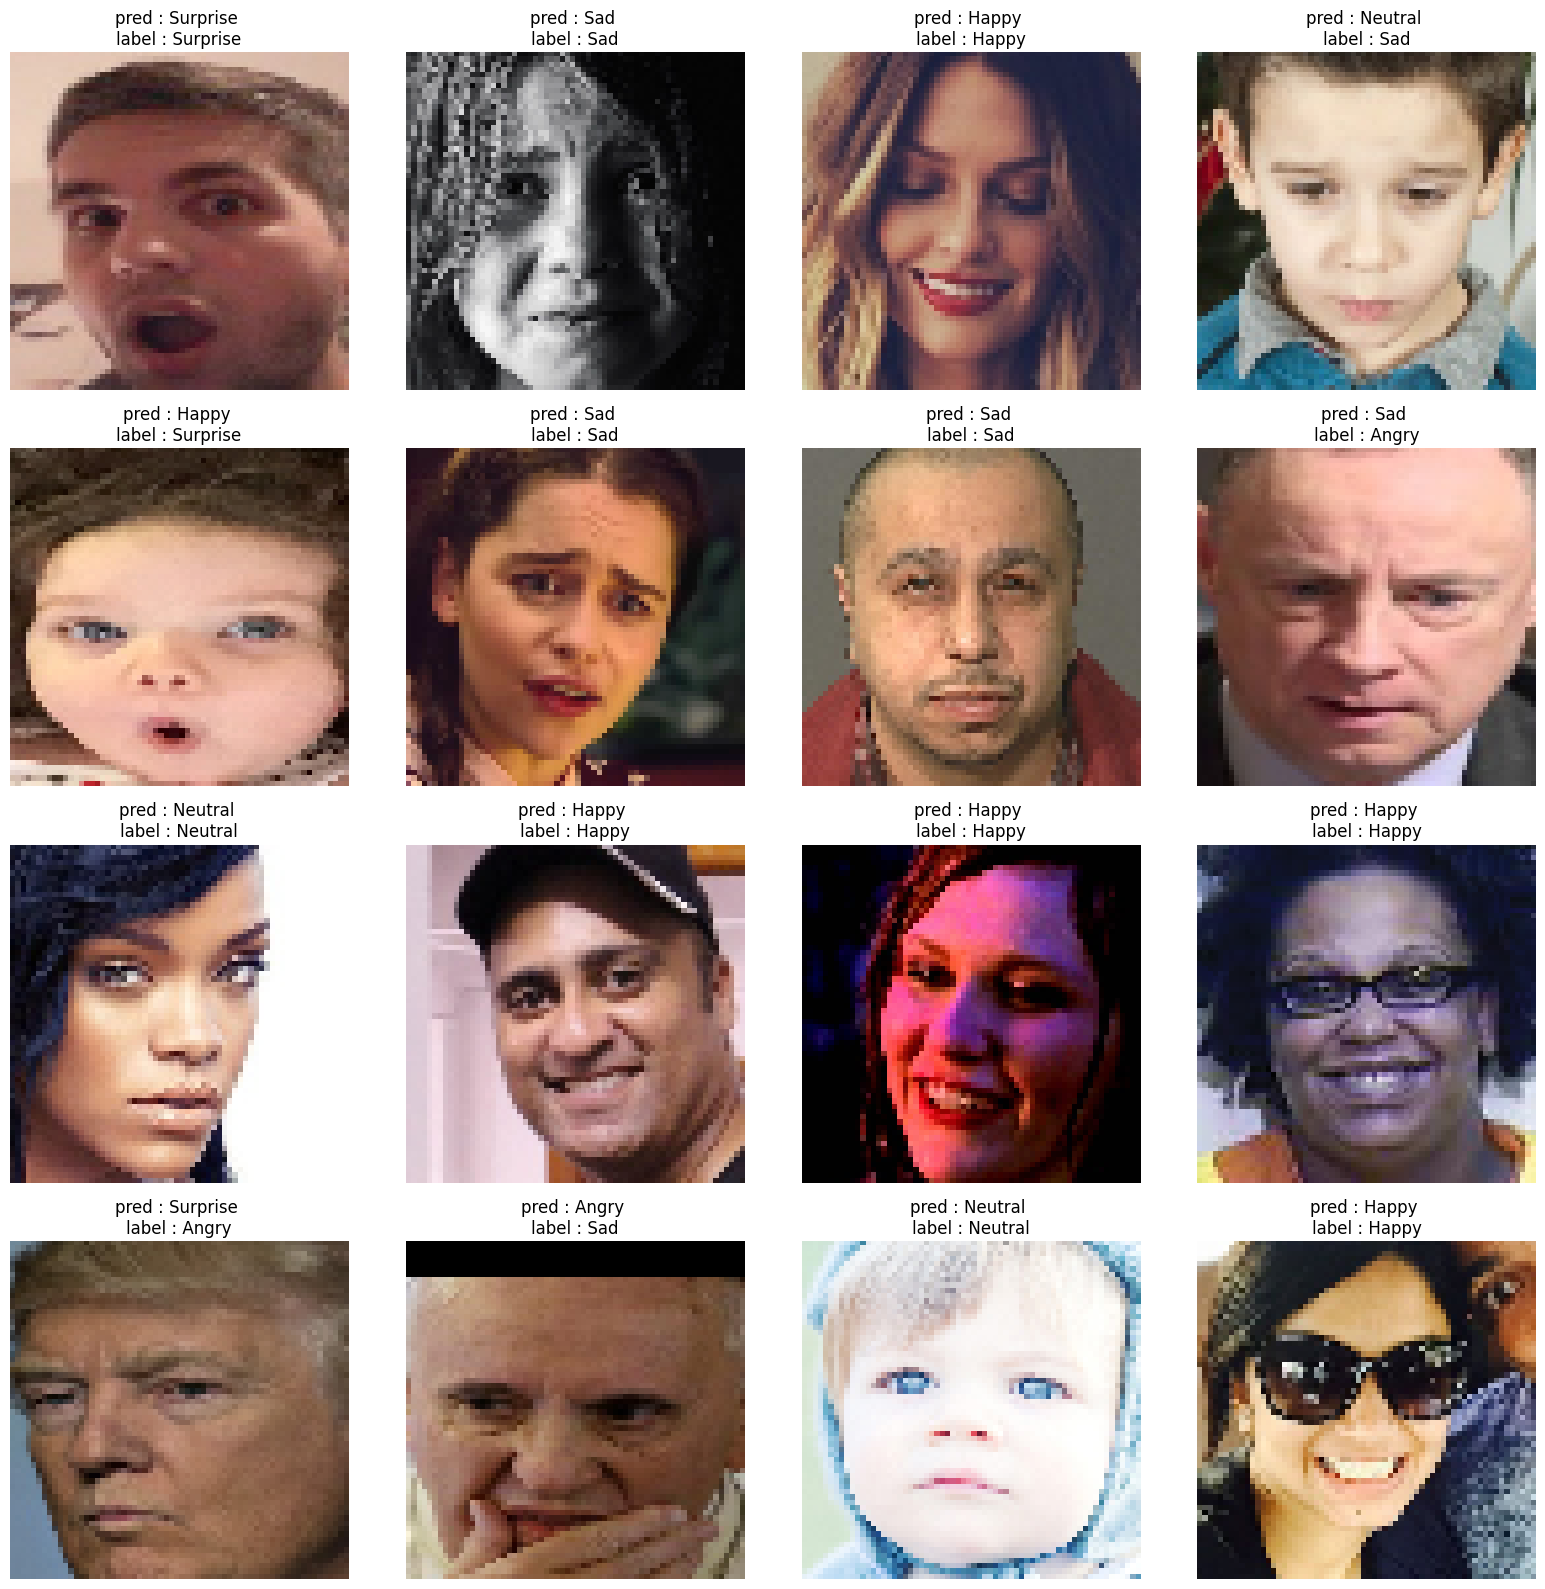

In [ ]:
fig , axes = plt.subplots(4,4,figsize=(16,16))
for i in range(4):
  for j in range(4):
    axes[i,j].imshow(X_test[i*4+j])
    axes[i,j].set_title(f"pred : {auto_index_df.iloc[preds[i*4+j]]['label']} \nlabel : {auto_index_df.iloc[y_test.argmax(axis=1)[i*4+j]]['label']}")
    axes[i,j].axis('off')
fig.tight_layout()

##⚡ Keras

### 🌟 What is Keras?

**Keras** is a high-level deep learning framework designed to make building and training neural networks both intuitive and efficient.  
Originally developed as an independent library, it is now fully integrated into **TensorFlow**, providing a clean and user-friendly interface for creating powerful deep learning models.

---

#### ✅ Why Keras?

Keras abstracts away much of the low-level complexity found in classical TensorFlow (v1), enabling rapid development without sacrificing flexibility.  
It is especially popular for:

- Prototyping CNNs, RNNs, and deep neural architectures quickly  
- Clean and readable code  
- Easy debugging and experimentation  
- Built-in support for layers, optimizers, losses, callbacks, and regularization  

---

#### 🧠 How Keras Works

Keras uses a **modular, layered design**, allowing models to be built by simply stacking layers in a sequence or customizing them through functional or subclassing APIs.

Instead of manually defining graph operations, Keras handles:
- weight initialization  
- intermediate tensors  
- backpropagation  
- optimization  
- training loops  

behind the scenes — while giving you full control over the architecture and hyperparameters.

---

#### 🚀 Why Use Keras Here?

After demonstrating the low-level construction of a CNN using TensorFlow (v1), using Keras allows us to:

- implement the same architecture with significantly cleaner code  
- focus on experimentation rather than boilerplate  
- train and evaluate the model with simpler commands  
- leverage modern TensorFlow features automatically

Keras provides the ideal balance between ease of use and expressive power, making it a favorite for research, production, and rapid prototyping in deep learning.


In [1]:
!pip install tensorflow==2.19

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/emotion-recognition-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'emotion-recognition-dataset' dataset.
Path to dataset files: /kaggle/input/emotion-recognition-dataset


In [3]:
path

'/kaggle/input/emotion-recognition-dataset'

In [4]:
!cp -r /root/.cache/kagglehub/datasets/sujaykapadnis/emotion-recognition-dataset/versions/1 /content

cp: cannot stat '/root/.cache/kagglehub/datasets/sujaykapadnis/emotion-recognition-dataset/versions/1': No such file or directory


In [5]:
path = '/kaggle/input/emotion-recognition-dataset'

In [6]:
import pandas as pd

In [7]:
df_keras = pd.read_csv(f"{path}/data.csv",index_col=0)
df_keras

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise
...,...,...
15448,Angry/cropped_emotions.571245~angry.png,Angry
15449,Angry/cropped_emotions.232257~angry.png,Angry
15450,Angry/cropped_emotions.232276~angry.png,Angry
15451,Angry/0aa9ec997e4faa4499e0aa3efac5ab97db109423...,Angry


In [8]:
df_keras['label'].value_counts()

,count
label,
Neutral,4027
Sad,3934
Happy,3740
Angry,1313
Surprise,1234
Ahegao,1205


In [9]:
auto_index_df_keras = df_keras['label'].value_counts().reset_index().drop('count',axis=1).reset_index()

In [10]:
auto_index_df_keras['label'] == 'Neutral'

,label
0,True
1,False
2,False
3,False
4,False
5,False


In [11]:
auto_index_df_keras.iloc[0]

,0
index,0
label,Neutral


In [12]:
def label_to_id(x):
  return auto_index_df_keras[auto_index_df_keras['label']==x]['index'].values[0]

In [13]:
df_keras['label'] = df_keras['label'].apply(label_to_id)

In [14]:
df_keras

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,4
1,Surprise/cropped_emotions.100096~12fffff.png,4
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,4
3,Surprise/cropped_emotions.260779~12fffff.png,4
4,Surprise/cropped_emotions.263616~12fffff.png,4
...,...,...
15448,Angry/cropped_emotions.571245~angry.png,3
15449,Angry/cropped_emotions.232257~angry.png,3
15450,Angry/cropped_emotions.232276~angry.png,3
15451,Angry/0aa9ec997e4faa4499e0aa3efac5ab97db109423...,3


In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 20.0 MB/s eta 0:00:00


In [15]:
import cv2

In [16]:
X_keras = []
y_keras = []
for i in range(len(df_keras)):
  img = cv2.imread(f"{path}/dataset/{df_keras['path'].iloc[i]}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64,64))
  img = img/255
  X_keras.append(img)
  y_keras.append(df_keras.iloc[i]['label'])

In [17]:
import numpy as np

In [18]:
X_keras = np.array(X_keras)

In [19]:
X_keras.shape

(15453, 64, 64, 3)

In [21]:
y_keras = np.array(y_keras)

In [22]:
y_keras.shape

(15453,)

In [23]:
y_keras = np.eye(6)[y_keras]

In [24]:
from sklearn.model_selection import train_test_split
X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X_keras, y_keras, test_size=0.3, random_state=42)

🔄 Switching to Keras Implementation

At this stage, all the necessary preprocessing steps have already been explained —  
including dataset loading, label encoding, image resizing, normalization, and splitting into training/testing subsets (as demonstrated in the TensorFlow section).

Now, we transition to building the model using **Keras**, a high-level API built on top of TensorFlow.  
Keras greatly simplifies the process of constructing neural networks, allowing us to define layers and architectures in a more intuitive and concise way.

Using `tensorflow.keras`, we can implement the same CNN structure — but with clearer syntax, reduced boilerplate, and easier experimentation.


In [25]:
from tensorflow.keras import models, layers

### 🧠 Designing the CNN Architecture with Keras

Using the Keras Sequential API, we build a clean and structured Convolutional Neural Network tailored for facial emotion recognition.  
This architecture mirrors the design implemented earlier using TensorFlow, but with improved readability and simplicity.

---

#### 🔷 Convolutional Blocks (Feature Extraction)

The architecture is organized into **three convolutional blocks**, each composed of:

- Two `Conv2D` layers with **3×3 kernels** (VGG-style)  
- `BatchNormalization` to stabilize and accelerate training  
- A `MaxPooling2D` layer to reduce spatial dimensions  

Each block progressively increases the number of filters:

- **Block 1:** 32 filters → learns low-level textures and edges  
- **Block 2:** 64 filters → identifies patterns and shapes  
- **Block 3:** 128 filters → captures high-level facial features necessary for emotion classification  

This layered structure allows the network to extract increasingly meaningful and abstract representations of the input images.

---

#### 🌀 Global Average Pooling (GAP)

Instead of flattening the feature maps into a large vector, the architecture uses **Global Average Pooling**.  
GAP reduces each feature map to a single value, drastically lowering the number of parameters and preventing overfitting—especially important for smaller datasets like emotion recognition.

It also provides smoother, more generalizable representations compared to traditional flattening.

---

#### 🔶 Dense Layers (Classification Head)

After feature extraction, the model transitions to fully connected layers:

- A **Dense layer with 256 units** and **ReLU activation**, regularized with L2 penalty to reduce overfitting  
- A **Dropout layer (40%)** to further improve generalization by randomly disabling neurons during training  
- A final **Dense layer with 6 units** and **softmax activation**, producing class probabilities for the six emotions  

This classification head balances expressive power and regularization, ensuring strong performance even with limited training data.

---

#### ⭐ Why This Architecture Performs Better

- **3×3 convolutions** extract richer features  
- **Batch normalization** improves stability and speeds up convergence  
- **Deeper structure** captures subtle facial expressions  
- **Global average pooling** eliminates unnecessary parameters  
- **L2 regularization + dropout** combat overfitting  
- **Clean, modular design** allows easy scaling and experimentation  

Together, these improvements create a robust and efficient CNN capable of learning fine-grained emotional cues with higher accuracy.



In [26]:
model = models.Sequential()

In [27]:
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()

# -----------------------------
# Block 1
# -----------------------------
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same',
                        input_shape=(64,64,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

# -----------------------------
# Block 2
# -----------------------------
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

# -----------------------------
# Block 3
# -----------------------------
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

# -----------------------------
# Replace Flatten with GAP
# -----------------------------
model.add(layers.GlobalAveragePooling2D())

# -----------------------------
# Dense layers
# -----------------------------
model.add(layers.Dense(256, activation='relu',
                       kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(6, activation='softmax'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# model.add(layers.Conv2D(32,4,activation='relu',input_shape=(64,64,3),padding='Same')) # 64 64 32
# model.add(layers.MaxPooling2D()) #32 32 32
# model.add(layers.Conv2D(64,4,activation='relu',padding='Same')) # 32 32 64
# model.add(layers.MaxPooling2D()) # 16 16 64
# model.add(layers.Conv2D(128,3,activation='relu',padding='Same')) # 16 16 128
# model.add(layers.MaxPooling2D()) # 8 8 128

# model.add(layers.Flatten())

# model.add(layers.Dense(1024,activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(100,activation='relu'))
# model.add(layers.Dense(6,activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 📋 Reviewing the Model Architecture

The `model.summary()` command provides a clear, layer-by-layer overview of the CNN architecture.  
It displays:

- each layer’s name and type  
- output shapes at every stage  
- the number of trainable parameters  

This summary is an essential diagnostic tool, helping verify that the architecture matches the intended design and ensuring that all dimensions flow correctly through the network.  
It also gives insight into the model’s complexity and computational requirements.


In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,366 (1.23 MB)

 Trainable params: 322,470 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

### ⚙️ Compiling the Model

Before training the network, we configure how it will learn by specifying the optimizer, loss function, and evaluation metrics.

- **Optimizer: Adam**  
  A widely used optimization algorithm that adapts learning rates dynamically.  
  It provides fast, stable convergence and performs exceptionally well in deep learning tasks.

- **Loss Function: Categorical Crossentropy**  
  Ideal for multi-class classification problems where labels are one-hot encoded.  
  It measures the difference between predicted probabilities and true class labels, guiding the model to minimize classification error.

- **Metric: Accuracy**  
  Tracks how often the model’s predictions match the true labels during training and evaluation.  
  This provides an intuitive and immediate understanding of performance.

Compiling the model prepares it for training and defines the rules by which it learns from the data.


In [29]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
X_train_keras.shape

(10817, 64, 64, 3)

In [31]:
y_train_keras.shape

(10817, 6)

### 🚀 Training the Keras Model

The `model.fit()` function initiates the training process, allowing the CNN to learn emotion patterns from the labeled images.

- **X_train_keras, y_train_keras** → the training dataset  
- **epochs = 200** → the model passes through the entire training set twice  
- **batch_size = 200** → the model updates its weights after processing every 200 examples  

During training, the network repeatedly:
1. performs forward propagation to compute predictions  
2. calculates the loss based on the prediction error  
3. updates its weights using backpropagation through the Adam optimizer  

Even with only two epochs, this step allows the model to begin capturing meaningful visual patterns, improving its ability to classify facial emotions.


In [43]:
model.fit(X_train_keras,y_train_keras,epochs=200,batch_size=200)

Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9996 - loss: 0.0085
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 1.0000 - loss: 0.0072
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9954 - loss: 0.0231
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9912 - loss: 0.0374
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9968 - loss: 0.0213
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9992 - loss: 0.0134
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9993 - loss: 0.0118
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9946 - loss: 0.0250
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9978 - loss: 0.0181
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9944 - loss: 0.0290
Epoch 11/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9956 - loss: 0.0253
Epoch 12/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/ste

### 🔍 Making Predictions on the Test Set

After training, the model is ready to evaluate its performance on unseen data.  
Using `model.predict(X_test_keras)`, we generate the predicted probability distributions for each test image.

- Each output vector contains six values (one per emotion class).  
- The highest probability indicates the model’s predicted emotion.  
- These predictions will later be compared against the true labels to assess accuracy and generate evaluation metrics.

This step shows how well the trained CNN generalizes beyond the training data and provides the foundation for performance analysis.



In [44]:
preds_keras = model.predict(X_test_keras)
preds_keras

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[4.68579771e-08, 1.66508340e-09, 1.92575609e-08, 1.66618346e-08,
        9.99999762e-01, 1.32300841e-07],
       [4.12163317e-01, 5.68292916e-01, 1.85435787e-02, 5.34625469e-05,
        7.37132577e-05, 8.73014797e-04],
       [1.36940643e-12, 3.84228188e-04, 9.99615788e-01, 3.29561170e-11,
        2.90983349e-10, 4.91669150e-10],
       ...,
       [1.96733385e-12, 3.59831387e-09, 9.99998093e-01, 1.49638282e-07,
        9.80755299e-09, 1.83998645e-06],
       [1.04625484e-04, 1.03274897e-06, 9.99893785e-01, 3.22892276e-07,
        1.54354083e-07, 8.12243286e-08],
       [1.21899306e-04, 9.99861240e-01, 1.04297578e-05, 4.09751510e-06,
        2.04199569e-06, 2.47624143e-07]], dtype=float32)

### 📊 Evaluating Keras Performance

To understand how well the model performs on unseen data, we generate a **classification report** using `scikit-learn`.  
This report provides a detailed breakdown of key performance metrics for each emotion class:

- **Precision** → How many predicted labels were correct  
- **Recall** → How many actual labels were correctly identified  
- **F1-score** → Harmonic mean of precision and recall  
- **Support** → Number of samples per class  

These metrics give a comprehensive view of the model’s strengths and areas for improvement across all emotion categories.

---

### 🖼️ Visualizing Predictions

To make evaluation more intuitive, we plot a grid of test images alongside their predicted and true labels:

- The image grid (4×4) displays 16 samples from the test set.  
- Each subplot shows the model’s predicted emotion and the actual label.  
- Visualization helps assess:
  - how well the model recognizes facial patterns  
  - where misclassifications occur  
  - whether certain emotions are harder to detect  

This combination of **quantitative metrics** and **qualitative visual inspection** gives a complete understanding of the CNN’s performance and generalization ability.


In [45]:
from sklearn.metrics import classification_report, accuracy_score

In [46]:
auto_index_df_keras['label'].values

array(['Neutral', 'Sad', 'Happy', 'Angry', 'Surprise', 'Ahegao'],
      dtype=object)

In [47]:
print(classification_report(y_test_keras.argmax(axis=1),preds_keras.argmax(axis=1),
                            target_names=auto_index_df_keras['label'].values))

              precision    recall  f1-score   support

     Neutral       0.69      0.69      0.69      1197
         Sad       0.68      0.71      0.70      1202
       Happy       0.90      0.89      0.90      1137
       Angry       0.70      0.67      0.68       368
    Surprise       0.84      0.64      0.73       363
      Ahegao       0.82      0.97      0.89       369

    accuracy                           0.76      4636
   macro avg       0.77      0.76      0.76      4636
weighted avg       0.76      0.76      0.76      4636



In [80]:
keras_accuracy = accuracy_score(y_test_keras.argmax(axis=1),preds_keras.argmax(axis=1))
keras_accuracy

0.7616479723899914

In [83]:
import matplotlib.pyplot as plt

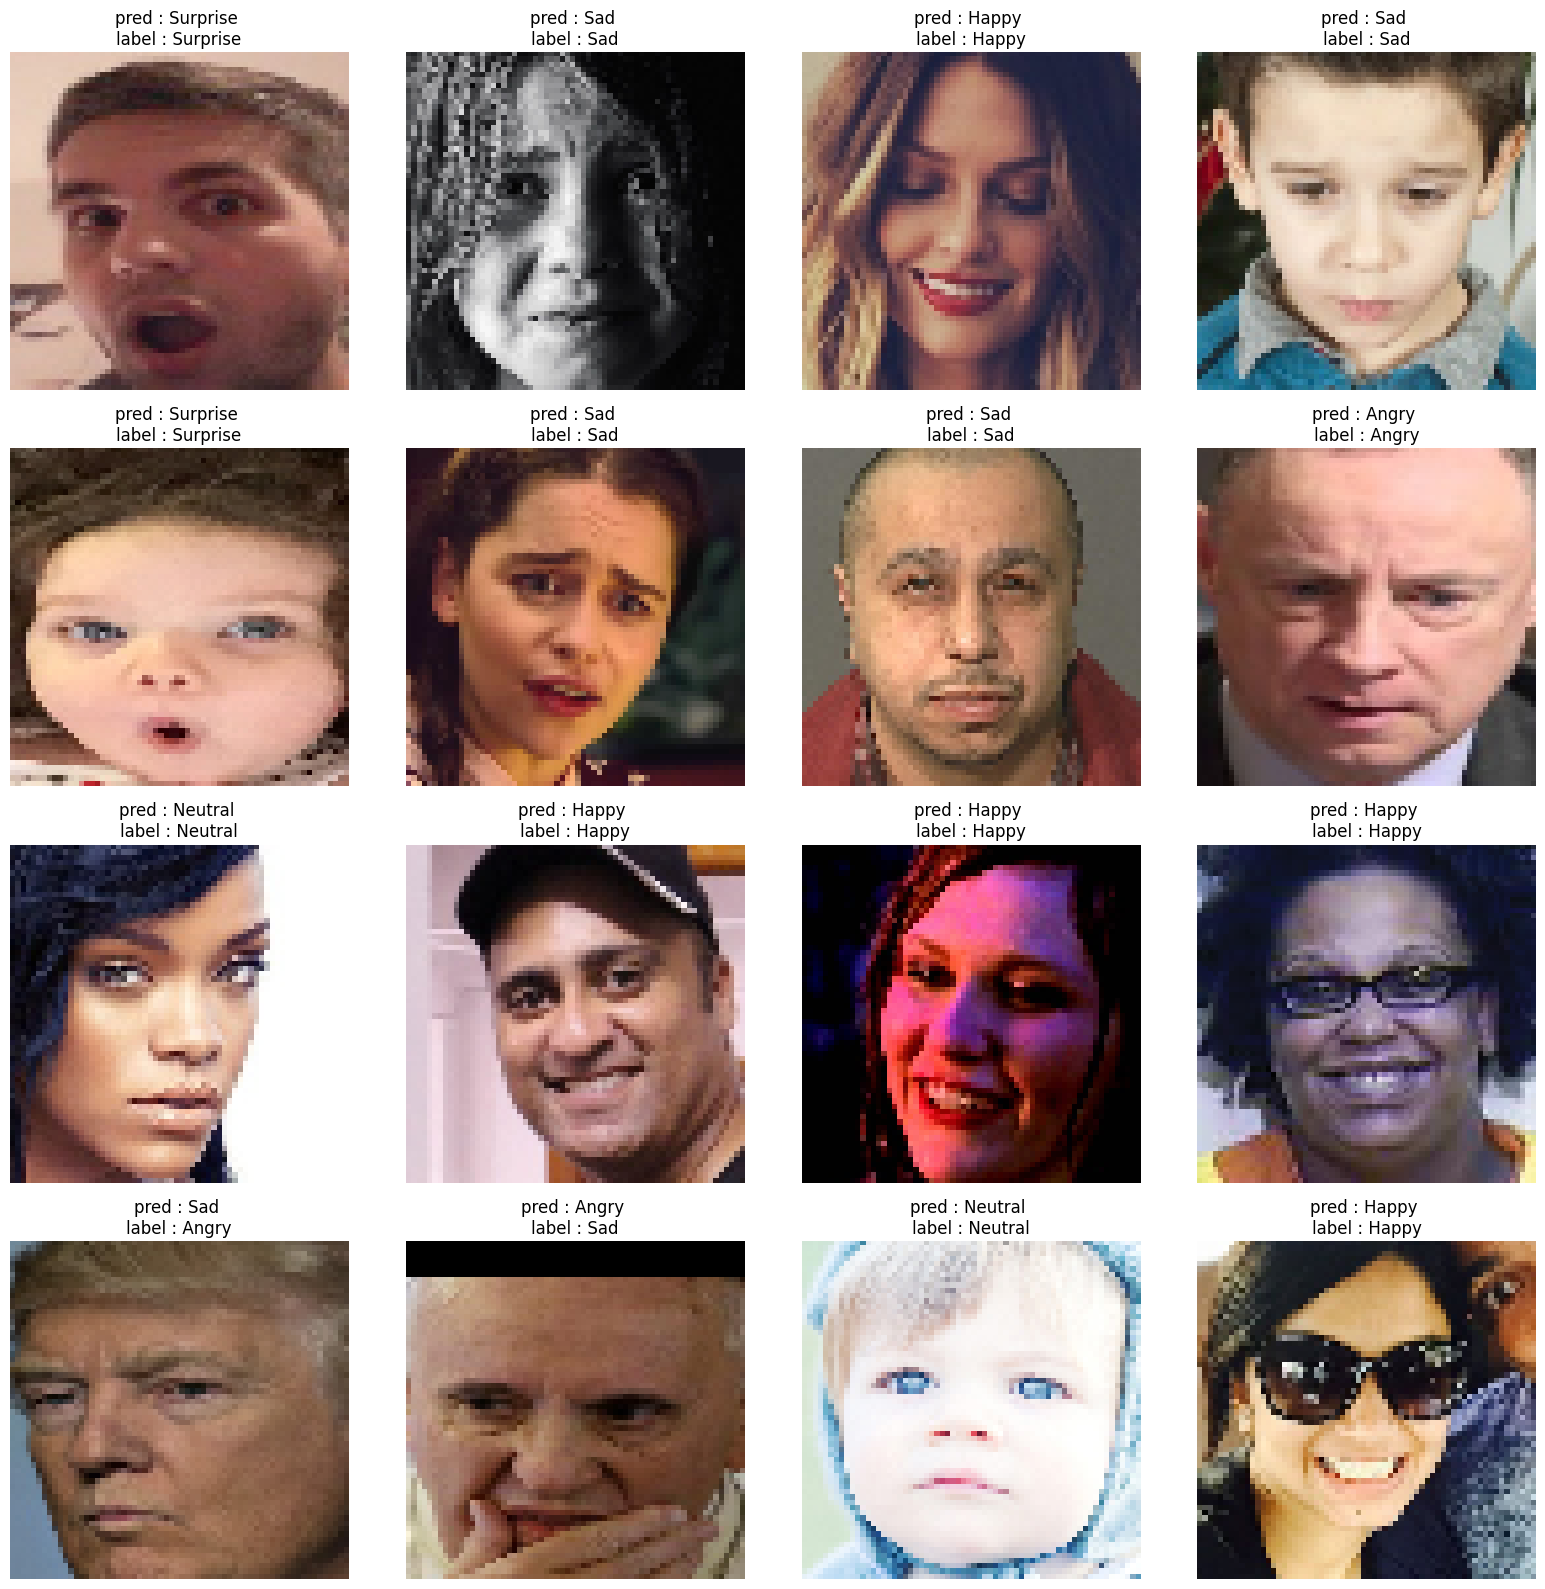

In [84]:
fig , axes = plt.subplots(4,4,figsize=(16,16))
for i in range(4):
  for j in range(4):
    axes[i,j].imshow(X_test_keras[i*4+j])
    axes[i,j].set_title(f"pred : {auto_index_df.iloc[preds_keras.argmax(axis=1)[i*4+j]]['label']} \nlabel : {auto_index_df.iloc[y_test_keras.argmax(axis=1)[i*4+j]]['label']}")
    axes[i,j].axis('off')
fig.tight_layout()

# 📊 **Creating a Table for Visualizing and Comparing Methods**

To summarize our results, we compile all model performances into a comparison table. This helps us:
- Identify the most effective feature-model combinations  
- Observe trends across representation types  
- Make informed decisions about trade-offs between accuracy and interpretability


In [81]:
import plotly.graph_objects as go

# Calculate evaluation metrics for each model
models = ['Tensorflow', 'Keras']

accuracy_scores = [tensorflow_accuracy, keras_accuracy]

# Plotting the comparison using Plotly
fig = go.Figure()

# Add traces for each evaluation metric
fig.add_trace(go.Bar(
    x=models,
    y=accuracy_scores,
    name='Accuracy',
    marker_color='blue'
))

# Customize the layout of the figure
fig.update_layout(
    title="Model Performance Comparison",
    barmode='group',  # Group the bars together for each model
    xaxis_title="Models",
    yaxis_title="Scores",
    template="plotly_dark",  # Dark theme for the plot
    legend_title="Metrics",
    font=dict(family="Arial, sans-serif", size=14),
    height=500,  # Adjust the height of the chart
    width=800,  # Adjust the width of the chart
)

# Show the plot
fig.show()

In [82]:
# Create a pandas DataFrame for the evaluation metrics
performance_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores
})

# Sort the table by Accuracy (or any other metric, e.g., 'F1 Score')
performance_df_sorted = performance_df.sort_values(by='Accuracy', ascending=False)

# Display the sorted table
print(performance_df_sorted.to_string(index=False))

     Model  Accuracy
     Keras  0.761648
Tensorflow  0.651569


## 🏁 Conclusion

This project demonstrates a complete end-to-end pipeline for facial emotion recognition using deep learning.  
By implementing the model architecture twice — once using low-level TensorFlow operations and once using the high-level Keras API — we gain both theoretical understanding and practical efficiency.

The final results highlight the strengths of both approaches:

| Model       | Accuracy   |
|-------------|------------|
| **Keras**   | **0.7616** |
| TensorFlow  | 0.6515     |

The Keras implementation achieves the highest accuracy, benefiting from its cleaner abstraction, optimized layers, and streamlined training workflow.  
Meanwhile, the TensorFlow version provides valuable insights into the inner mechanics of CNN construction, parameter management, and graph-based computation.

Overall, the models successfully learned to recognize and classify emotions from facial images with promising accuracy.  
Future improvements — such as data augmentation, deeper architectures, or hyperparameter tuning — could further boost performance and enhance the model’s ability to capture subtle emotional expressions.

This project showcases both the **power of modern deep learning tools** and the importance of understanding the foundational concepts behind them.


## 🌍 Practical Applications of This Emotion Detection System

Emotion detection powered by deep learning has a wide range of impactful real-world applications.  
By automatically interpreting facial expressions, this system can enhance human–computer interaction and enable smarter, more adaptive technologies.  

Below are some key domains where such a model can be applied:

---

#### 🎮 1. Human–Computer Interaction  
Emotion-aware interfaces can adjust their responses based on the user’s emotional state.  
This leads to more intuitive, personalized experiences in applications such as:

- adaptive user interfaces  
- emotion-driven game mechanics  
- virtual assistants with emotional intelligence  

---

#### 🧠 2. Mental Health Monitoring  
Automated emotion recognition can support early detection of emotional distress or unusual behavioral patterns. It can assist in:

- remote therapy and telemedicine  
- stress and mood tracking  
- monitoring emotional well-being in vulnerable populations  

---

#### 🎓 3. Education and Learning Analytics  
In modern digital classrooms, emotion detection helps understand student engagement levels. It can be used to:

- identify confusion or frustration  
- optimize teaching strategies in real time  
- improve remote learning experiences  

---

#### 🛍️ 4. Customer Experience & Retail Analytics  
Businesses can leverage emotional insights to better understand customer reactions. Applications include:

- tracking customer satisfaction  
- analyzing emotional responses to products or advertisements  
- improving user engagement and service personalization  

---

#### 🔐 5. Security & Surveillance  
Emotion recognition can detect signs of fear, stress, or suspicious behavior in high-security environments.  
It can assist with:

- identifying unusual emotional patterns  
- enhancing threat detection systems  
- supporting behavioral analysis  

---

#### 🎥 6. Entertainment & Media  
Emotion detection can transform how audiences interact with media content. Examples include:

- personalized movie or music recommendations  
- adaptive storytelling  
- emotion-responsive content creation tools  

---

In summary, this emotion detection system has broad potential across multiple industries — enhancing safety, improving user experience, and enabling emotionally intelligent technologies.  
Its flexibility and adaptability make it an exciting foundation for future innovations in AI-driven human understanding.
